In [106]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import datetime as d
import matplotlib.pylab as plt
from itertools import islice

import swellEx_env
from matchedField import MFP
import loadCSDM as cm
from beamformers import wnc_bisection as wnc
from normalMode import Chinook

In [107]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
tStart = 400
year = str(1996)
experimentStart = d.datetime.strptime(year + dataFile[-22:-14],\
                                      '%YJ%j%H%M')
snapLength = 1
snapStep = 0.5
numSnaps = 1
sD = 54

wnc_maxNorm = 1.5

In [108]:
# frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
frequencies = [49, 64, 79, 94, 112, 130, 148]
# frequencies = [49, 112, 130]
# frequencies = [49]

decimation = 10
fB_width = 300
enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray = False)

# Match field boundries
zMax = enviornment.getProfile(0.).getZatInterface()[1]
rMax = 1e4  # m

In [109]:
numR = 100
numZ = 50
# numR = 50
# numZ = 25
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[10:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [110]:
fOfInterest = frequencies
matchedField = MFP(enviornment, rPlot, zPlot, frequencies, sensorPosition)
matchedField.makeLookVectors()

In [111]:
# Load K from data
dataIter = cm.SnapshotLoad(dataFile, fs, tStart, snapLength, snapStep,
                          channelNames = sensorPosition.index)
processingFunction = cm.NarrowBandPressure(fOfInterest)
kGen = cm.CSDM(dataIter, processingFunction, numSnaps, startTime = experimentStart)
K_fromData = iter(kGen)

In [112]:
# Synthetic K
models = []
for f in frequencies:
    nm_model = Chinook(f, enviornment)
    nm_model.calculateModes_eig(fB_width, decimation)
    models.append(nm_model)

In [113]:
K = next(K_fromData)
B_bart = matchedField.csdmMF(K, wnc, True, wnc_maxNorm)
sourceRange = swellEx_env.getRangeAtTime(K.iloc[0].index.name)

K_model = []
for m in models:
    p = m.calculatePressure(sD, sensorPosition.values, sourceRange * 1e3)
    K_model.append(np.outer(p, np.conj(p)))
K_model = pd.Series(K_model, index = frequencies)

B_bart2 = matchedField.csdmMF(K_model, wnc, True, wnc_maxNorm)

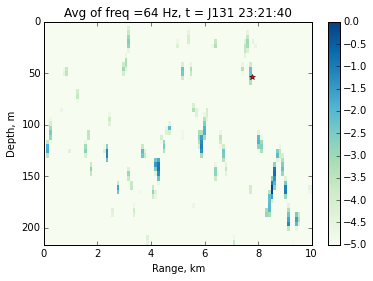

In [118]:
# indexForAvg = np.arange(len(fOfInterest))
# indexForAvg = [0,1,2,3,4,5,6]
plotI = 1
_ = plt.pcolormesh(R_nm / 1e3, Z, B_bart.iloc[plotI].T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Avg of freq =' + str(np.array(fOfInterest)[plotI]) +\
              ' Hz, t = ' + K.iloc[0].index.name.strftime('J%j %H:%M:%S'))
_ = plt.plot(swellEx_env.getRangeAtTime(K.iloc[0].index.name), sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

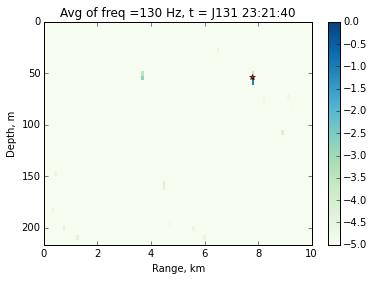

In [115]:
_ = plt.pcolormesh(R_nm / 1e3, Z, B_bart2.iloc[plotI].T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Avg of freq =' + str(np.array(fOfInterest)[plotI]) +\
              ' Hz, t = ' + K.iloc[0].index.name.strftime('J%j %H:%M:%S'))
_ = plt.plot(swellEx_env.getRangeAtTime(K.iloc[0].index.name), sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

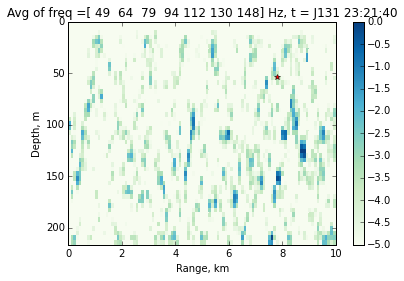

In [116]:
# indexForAvg = np.arange(len(fOfInterest))
indexForAvg = [0,1,2,3,4,5,6]
# indexForAvg = [0,2] #,2,3,4,5,6]
avgBart = np.sum(np.dstack(B_bart)[:,:,indexForAvg], axis = 2)\
    / len(indexForAvg)
avgBart = avgBart - np.max(avgBart)
_ = plt.pcolormesh(R_nm / 1e3, Z, avgBart.T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Avg of freq =' + str(np.array(fOfInterest)[indexForAvg]) +\
              ' Hz, t = ' + K.iloc[0].index.name.strftime('J%j %H:%M:%S'))
_ = plt.plot(swellEx_env.getRangeAtTime(K.iloc[0].index.name), sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')